In [9]:
import numpy as np
import matplotlib.pyplot as plt
from dataset_q1 import CustomTimeSeriesDataset, weighted_sampler_dataloader
from torch.utils.data import DataLoader
import torch
from model_q1 import ResCNN
from copy import deepcopy
from sklearn.decomposition import PCA
import umap

In [2]:
model = ResCNN()
nettype = 'CNN'
model_parameters_path = "./Model_Parameters/ResCNN_mitbih_best_parameters.pth"
model.load_state_dict(torch.load(model_parameters_path))
# print(model)

encoder_q1 = deepcopy(model)
del encoder_q1.fc1
del encoder_q1.fc2

# Freeze all parameters
for i, param in enumerate(encoder_q1.parameters()):
    param.requires_grad = False

# Modify forward function
def new_forward(self, x):
    out=self.bn1(self.conv1(x))
    out=self.resblock3(self.resblock2(self.resblock1(out)))
    out=self.maxpoolf(out)
    out=out.view(out.size(0), -1)
    return out

encoder_q1.forward = new_forward.__get__(encoder_q1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
encoder_q1.to(device)

cpu


ResCNN(
  (conv1): Conv1d(1, 24, kernel_size=(5,), stride=(3,), padding=(1,))
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (resblock1): ResBlock(
    (conv1): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ELU(alpha=1.0)
  )
  (resblock2): ResBlock(
    (conv1): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(24, 24, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ELU(alpha=1.0)
  )
  (resblock3): ResBlock(
    (conv1): Conv1d(24, 24, kernel_size=(3

In [4]:
# Load MIT-BIH
mitbih_train_dataset = CustomTimeSeriesDataset('mitbih_train.csv', NetType=nettype)
mitbih_train_loader = DataLoader(mitbih_train_dataset, batch_size=len(mitbih_train_dataset), shuffle=False)
mitbih_test_dataset = CustomTimeSeriesDataset('mitbih_test.csv', NetType=nettype)
mitbih_test_loader = DataLoader(mitbih_test_dataset, batch_size=len(mitbih_test_dataset), shuffle=False)

# Load PTB
ptb_train_dataset = CustomTimeSeriesDataset('ptbdb_train.csv', NetType=nettype)
ptb_train_loader = DataLoader(ptb_train_dataset, batch_size=len(ptb_train_dataset), shuffle=False)
ptb_test_dataset = CustomTimeSeriesDataset('ptbdb_test.csv', NetType=nettype)
ptb_test_loader = DataLoader(ptb_test_dataset, batch_size=len(ptb_test_dataset), shuffle=False)

In [5]:
print('mitbih_train: ', len(mitbih_train_dataset))
print('mitbih_test: ', len(mitbih_test_dataset))
print('ptb_train: ', len(ptb_train_dataset))
print('ptb_test: ', len(ptb_test_dataset))

mitbih_train:  87553
mitbih_test:  21891
ptb_train:  11640
ptb_test:  2910


In [6]:
mitbih_features = []
mitbih_labels = []

encoder_q1.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(mitbih_train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        features = encoder_q1(inputs)
        mitbih_features.append(features.numpy())
        mitbih_labels.append(labels)
    for i, (inputs, labels) in enumerate(mitbih_test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        features = encoder_q1(inputs)
        mitbih_features.append(features.numpy())
        mitbih_labels.append(labels)
        
# Concatenate features and labels lists
mitbih_features = np.concatenate(mitbih_features, axis=0)
mitbih_labels = np.concatenate(mitbih_labels, axis=0)

# Check shapes
print("mitbih_features shape:", mitbih_features.shape)
print("mitbih_labels shape:", mitbih_labels.shape)

mitbih_features shape: (109444, 744)
mitbih_labels shape: (109444, 1)


In [14]:
ptbdb_features = []
ptbdb_labels = []

encoder_q1.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(ptb_train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        features = encoder_q1(inputs)
        ptbdb_features.append(features.numpy())
        ptbdb_labels.append(labels)
    for i, (inputs, labels) in enumerate(ptb_test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        features = encoder_q1(inputs)
        ptbdb_features.append(features.numpy())
        ptbdb_labels.append(labels)
        
# Concatenate features and labels lists
ptbdb_features = np.concatenate(ptbdb_features, axis=0)
ptbdb_labels = np.concatenate(ptbdb_labels, axis=0)

# Check shapes
print("ptbdb_features shape:", ptbdb_features.shape)
print("ptbdb_labels shape:", ptbdb_labels.shape)

ptbdb_features shape: (14550, 744)
ptbdb_labels shape: (14550, 1)


### INSTALLING UMAP
https://github.com/lmcinnes/umap
- First try different parameters on smaller dataset

In [25]:
import umap.plot

- matplotlib
- pandas
- datashader
- bokeh
- holoviews
- dask

0
1
2
0
1
2


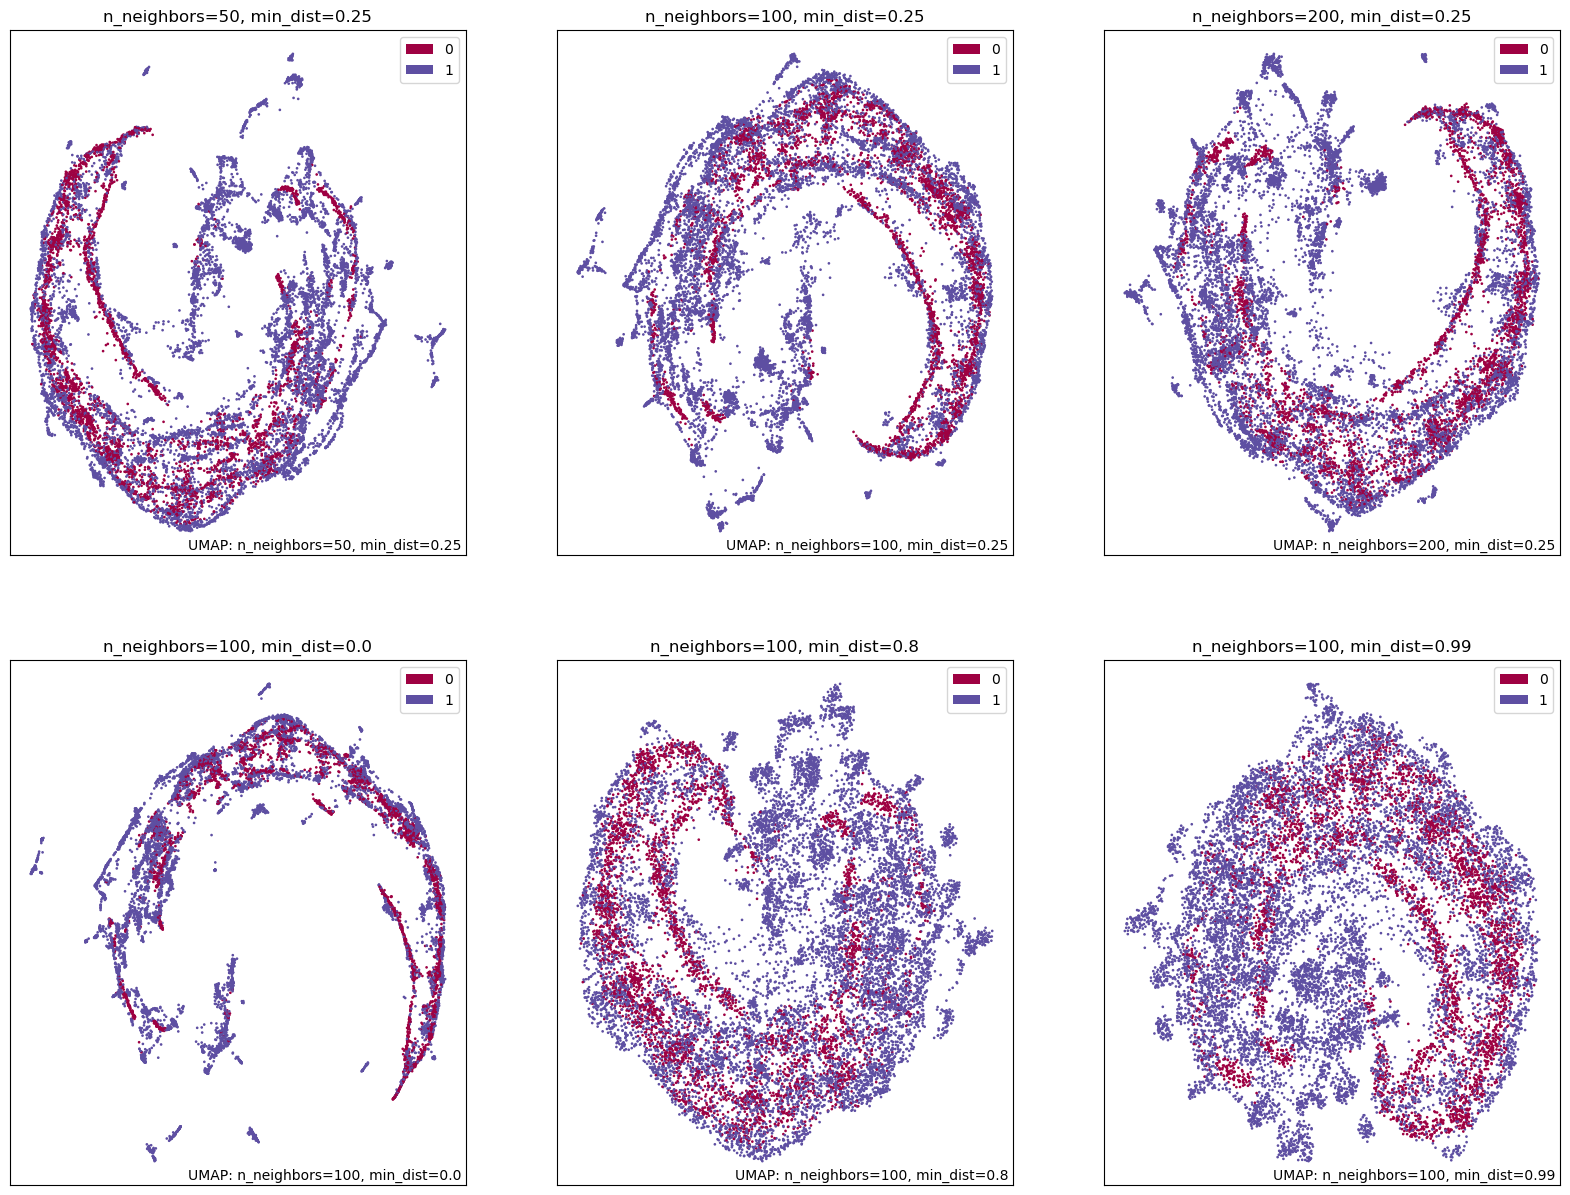

In [41]:
n_neighbors_values = np.array([50, 100, 200])
min_dist_values = np.array([0.0, 0.8, 0.99])

fig, axes = plt.subplots(2, 3, figsize=(20, 15))

for i, n_neighbors in enumerate(n_neighbors_values):
    print(i)
    umap_model = umap.UMAP(n_neighbors=n_neighbors,min_dist=0.25)
    embeddings = umap_model.fit_transform(ptbdb_features)
    umap_model.embedding_ = embeddings
    ax = axes[0, i]
    umap.plot.points(umap_model, labels=ptbdb_labels.squeeze(), ax=ax)
    ax.set_title(f'n_neighbors={n_neighbors}, min_dist=0.25')

for i, min_dist in enumerate(min_dist_values):
    print(i)
    umap_model = umap.UMAP(n_neighbors=100,min_dist=min_dist)
    embeddings = umap_model.fit_transform(ptbdb_features)
    umap_model.embedding_ = embeddings
    ax = axes[1, i]
    umap.plot.points(umap_model, labels=ptbdb_labels.squeeze(), ax=ax)
    ax.set_title(f'n_neighbors=100, min_dist={min_dist}')

In [48]:
X = PCA(n_components=50).fit_transform(mitbih_features)
X.shape

(109444, 50)

In [62]:
from tqdm import tqdm

min_dist_values = np.array([0.0125, 0.05, 0.2, 0.8])
n_neighbors_values = np.array([20, 50, 80, 100])

# Create subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for i, min_dist in enumerate(min_dist_values):
    for j, n_neighbors in enumerate(tqdm(n_neighbors_values)):
        # Perform UMAP on the features with current min_dist and n_neighbors
        umap_model = umap.UMAP(min_dist=min_dist, n_neighbors=n_neighbors)
        embeddings = umap_model.fit_transform(X)

        # Plot UMAP embeddings with labels
        ax = axes[i, j]
        scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1], c=mitbih_labels, cmap=plt.cm.plasma)
        ax.set_title(f'UMAP(min_dist={min_dist}, n_neighbors={n_neighbors})')
        ax.set_axis_off()

# Add a shared colorbar
fig.colorbar(scatter, ax=axes.ravel().tolist(), orientation='vertical', label='Classes')
plt.tight_layout()
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]